<a href="https://colab.research.google.com/github/kamilMlynarczykk/projekt-Speech-emotion-recognition/blob/main/Speech_Emotion_Recognition_80percent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Wypakowywanie folderow .zip z plikami audio


In [ ]:
!unzip /content/drive/MyDrive/WUM/Recordings/CREMAD.zip -d /content/CREMAD
!unzip /content/drive/MyDrive/WUM/Recordings/TESS.zip -d /content/TESS
!unzip /content/drive/MyDrive/WUM/Recordings/SAVEE.zip -d /content/SAVEE
!unzip /content/drive/MyDrive/WUM/Recordings/RAVDESS.zip -d /content/RAVDESS

## 2. Wczytywanie ścieżek z folderów i zapis jako dataframe do pliku CSV


In [33]:
import time

import pandas
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display


import warnings
warnings.filterwarnings('ignore')

### Wczytanie ścieżek i etykiet następnie zapis do list

In [34]:
# Initialize lists to store paths and labels
paths = []
labels = []

# Crema
for dirname, _, filenames in os.walk("../content/CREMAD/AudioWAV"):
    for filename in filenames:
        file_path = os.path.join(dirname, filename).replace("\\", "/")
        paths.append(file_path)
        label = filename.split('_')[-2]
        if label == "ANG":
            labels.append("angry")
        elif label == "DIS":
            labels.append("disgust")
        elif label == "FEA":
            labels.append("fear")
        elif label == "HAP":
            labels.append("happy")
        elif label == "NEU":
            labels.append("neutral")
        elif label == "SAD":
            labels.append("sad")
print('CREMA dataset is Loaded')
print(len(paths))
#TESS dataset
for dirname, _, filenames in os.walk('../content/TESS/TESS Toronto emotional speech set data'):
    for filename in filenames:
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        if label != "ps":
          paths.append(os.path.join(dirname, filename).replace("\\", "/"))
          labels.append(label.lower())

print('TESS dataset is Loaded')
print(len(paths))
## Ravdess
for dirname, _, filenames in os.walk('../content/RAVDESS/audio_speech_actors_01-24'):
    for filename in filenames:
        label = filename.split('-')[2]
        if label != "02" and label !="08":
            paths.append(os.path.join(dirname, filename).replace("\\", "/"))

        if label == "01":
            labels.append("neutral")
        elif label == "03":
            labels.append("happy")
        elif label == "04":
            labels.append("sad")
        elif label == "05":
            labels.append("angry")
        elif label == "06":
            labels.append("fear")
        elif label == "07":
            labels.append("disgust")

print('RAVDESS dataset is Loaded')
print(len(paths))
#Savee
for dirname, _, filenames in os.walk('../content/SAVEE/ALL'):
    for filename in filenames:
        label = filename.split('_')[-1][0] if filename.split('_')[-1][1].isdigit() else filename.split('_')[-1][0:2]
        if label != "su":
          paths.append(os.path.join(dirname, filename).replace("\\", "/"))

        if label == "n":
            labels.append("neutral")
        elif label == "h":
            labels.append("happy")
        elif label == "sa":
            labels.append("sad")
        elif label == "a":
            labels.append("angry")
        elif label == "f":
            labels.append("fear")
        elif label == "d":
            labels.append("disgust")

print("SAVEE dataset is loaded")
print(len(paths))

CREMA dataset is Loaded
7442
TESS dataset is Loaded
9842
RAVDESS dataset is Loaded
10898
SAVEE dataset is loaded
11318


In [35]:
df = pd.DataFrame()
df["Speech"] = paths
df["labels"] = labels


In [36]:
df["labels"].value_counts()

labels
sad        1923
angry      1923
happy      1923
fear       1923
disgust    1923
neutral    1703
Name: count, dtype: int64

### Zapis do pliku CSV

In [37]:
df.to_csv("/content/drive/MyDrive/WUM/Recordings_Dataframe/data_path_WUM.csv",index=False)

## 3. Powiększanie zbioru danych poprzez filtry i ekstrakcja cech

### Wczytanie danych z pliku
Wczytanie podpisanych ścieżek audio z dysku google

In [38]:
import timeit
import warnings
warnings.filterwarnings('ignore')

import librosa
import librosa.display
import numpy as np
import pandas as pd

from tqdm import tqdm

In [39]:
df = pd.read_csv('/content/drive/MyDrive/WUM/Recordings_Dataframe/data_path_WUM.csv')

paths = df["Speech"].tolist()
labels = df["labels"].tolist()

oversampling z przefiltrowanych plikach: noise, stretch, pitch, shift

In [40]:
def noise(y):
    noise_amp = 0.035*np.random.uniform()*np.amax(y)
    y = y + noise_amp*np.random.normal(size=y.shape[0])
    return y

def stretch(y):
  return librosa.effects.time_stretch(y,rate=0.8)

def pitch_shift(y,sr):
  return librosa.effects.pitch_shift(y=y,sr=sr,n_steps=3)

### Metody ekstrakcji cech z pliku audio

In [ ]:
# Metoda MFCC
def extract_mfcc(n, y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n,hop_length=512)
    mfccs = np.mean(mfccs.T, axis=0)
    return mfccs

# Metoda Root Mean Squeare - RMS
def extract_rms(y):
    rms = np.mean(librosa.feature.rms(y=y,frame_length=2048,hop_length=512)[0])
    return np.squeeze(rms)

# Metoda Chroma-STFT
def extract_chroma(n, y, sr):
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma = n, hop_length=512)
    chroma = np.mean(chroma.T, axis=0)
    return chroma

# Metoda Zero Crossing Rate - ZCR
def extract_zcr(y):
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=y,frame_length=2048,hop_length=512)[0])
  return np.squeeze(zcr)

'''
Poniższe cechy podczas trenowania modelu okazały się nieprzydatne, uczenie modelu okazało się być zbyt kosztowne czasowo,
nie przetestowane na większej ilości epok

# Metoda Spectral Centroid
def extract_scectroid(y,sr):
  spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=2048, hop_length=512)[0][:30]
  return spectral_centroids  # Averaging spectral centroids

# Metoda Spectral Bandtwidth
def extract_sbandwidth(y,sr):
  spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=2048, hop_length=512)[0][:30]
  return spectral_bandwidth  # Averaging spectral centroids

# Metoda Spectral Contrast
def extract_scontrast(y,sr):
  spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=2048, hop_length=512)[0][:30]
  return spectral_contrast  # Averaging spectral centroids

# Metoda Spectral Flatness
def extract_sflatness(y,sr):
  spectral_flatness = librosa.feature.spectral_flatness(y=y, n_fft=2048, hop_length=512)[0][:30]
  return spectral_flatness  # Averaging spectral centroids

# Metoda Spectral Roll-off
def extract_srolloff(y,sr):
  spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=2048, hop_length=512)[0][:30]
  return spectral_rolloff  # Averaging spectral centroids
'''

In [42]:
def extract_features(y,sr, n_f_m, n_f_c):
  result = np.array([])
  mfcc = extract_mfcc(n = n_f_m, y=y, sr=sr)
  chroma = extract_chroma(n = n_f_c, y=y, sr=sr)
  zcr = extract_zcr(y=y)
  rms = extract_rms(y=y)
  #sCentroid = extract_scectroid(y=y,sr=sr)
  #sBandhwidth = extract_sbandwidth(y=y,sr=sr)
  #sContrast = extract_scontrast(y=y,sr=sr)
  #sFlatness = extract_sflatness(y=y,sr=sr)
  #sRolloff = extract_srolloff(y=y,sr=sr)
  result = np.hstack((result,
                      mfcc,
                      chroma,
                      zcr,
                      rms
                      #sCentroid,
                      #sBandhwidth,
                      #sContrast,
                      #sFlatness,
                      #sRolloff
                      ))

  return result

Pętla wykonująca ekstrakcje cech

In [ ]:
number_of_features_mfcc = 42
number_of_features_chroma = 24
start = timeit.default_timer()

X_f = []
result = np.array([])
new_labels = []
for path in tqdm(paths):
    y, sr = librosa.load(path, duration = 2.5, offset=0.5)

    if result.size == 0: result = extract_features(y,sr,number_of_features_mfcc, number_of_features_chroma)
    else: result = np.vstack((result,extract_features(y,sr,number_of_features_mfcc, number_of_features_chroma)))
    new_labels.append(labels[i])

    data_noise = noise(y)
    result = np.vstack((result,
                        extract_features(data_noise,sr,number_of_features_mfcc, number_of_features_chroma)))
    new_labels.append(labels[i])

    data_stretch = stretch(y)
    result = np.vstack((result,
                        extract_features(data_stretch,sr,number_of_features_mfcc, number_of_features_chroma)))
    new_labels.append(labels[i])

    data_pitch_shift = pitch_shift(y,sr)
    result = np.vstack((result,
                        extract_features(data_pitch_shift,sr,number_of_features_mfcc, number_of_features_chroma)))
    new_labels.append(labels[i])

end = timeit.default_timer()
print(f"Czas pętli: {(end-start)} sekund")

X_f = np.array(result)
X_f.shape

In [ ]:
word_to_int = {"angry": 0, "happy": 1, "sad": 2,"disgust": 3,"fear": 4,"neutral": 5}
y_1 = []
for i in range(len(new_labels)):
    if new_labels[i] in word_to_int:
        new_labels[i] = word_to_int[new_labels[i]]

y_1 = np.array(new_labels)
#y = np.array(new_labels)
y_1.shape

(45272,)

Zapisanie do pliku cech i labeli

In [ ]:
df = pd.DataFrame()

df["labels"] = y_1.tolist()
df["Features"] = X_f.tolist()
print(df.columns)
df.to_csv('/content/drive/MyDrive/WUM/Features/data_features_with_labels_dataframe_WUM.csv')
#df.to_csv('/content/drive/MyDrive/WUM/Features/data_features_with_labels_dataframe_WUM_276_30.csv',index=False)
#df.to_csv('/content/drive/MyDrive/WUM/Features/data_features_with_labels_dataframe_WUM_mfcc42_chroma24.csv',index=False)
#df.to_csv('/content/drive/MyDrive/WUM/Features/data_features_with_labels_dataframe_WUM_more_feature_methods.csv',index=False)
#df.to_csv('/content/drive/MyDrive/WUM/Features/data_features_with_labels_dataframe_WUM_more_feature_methods_first33.csv',index=False)

Index(['labels', 'Features'], dtype='object')


## 4. Konfiguracja bez wstępnego preprocessingu (cechy pobierane z pliku CSV)

Odczytanie z pliku cech i labeli

In [109]:
import time

import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import ast

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
!pip -q install torchmetrics
from torchmetrics import Accuracy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torch.utils.data import Dataset, DataLoader
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

TRAIN_PATH = '/content/drive/MyDrive/WUM/Train/train_labels_features_dataframe.csv'
TEST_PATH = '/content/drive/MyDrive/WUM/Test/test_labels_features_dataframe.csv'

## 5. Tworzenie modelu uczenia maszynowego

### Podział zbioru na treningowy i testowy i zapisanie do pliku

In [44]:
PATH_FILE = '/content/drive/MyDrive/WUM/Features/data_features_with_labels_dataframe_WUM.csv'


## Zamiana z string -> 1d liste -> 2d liste
def labels_and_features_from_csv(path_file):
    df = pd.read_csv(path_file)
    converted_features = []

    for feature_string in df['Features']:
        feature_list = ast.literal_eval(feature_string)
        converted_features.append(np.array(feature_list, dtype=float))

    X = np.vstack(converted_features)
    y = np.array(df['labels'])
    return y, X

y, X = labels_and_features_from_csv(PATH_FILE)

X.shape, y.shape

((45272, 68), (45272,))

In [45]:
TRAIN_PATH = '/content/drive/MyDrive/WUM/Train/train_labels_features_dataframe.csv'
TEST_PATH = '/content/drive/MyDrive/WUM/Test/test_labels_features_dataframe.csv'

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y)
scaler = StandardScaler()

# normalizacja danych
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
df_train = pd.DataFrame()
df_train["labels"] = y_train.tolist()
df_train["Features"] = X_train.tolist()

df_train.to_csv(TRAIN_PATH,index=False)

df_test = pd.DataFrame()
df_test["labels"] = y_test.tolist()
df_test["Features"] = X_test.tolist()


df_test.to_csv(TEST_PATH,index=False)

### Tworzenie torch.Dataset w celu możliwości iterowania dzięki torch.dataLoader

In [29]:
class torchDataset(Dataset):
    """
    A custom Dataset class for loading features and labels from a CSV file,
    where features are stored as string representations of lists that need
    to be converted to numpy arrays and then to Torch tensors.
    """
    def __init__(self, csv_file, device: str):
        """
        Args:
            csv_file (str): Path to the CSV file.
        """
        # Load the data from a CSV file
        self.df = pd.read_csv(csv_file)

        # Convert features from strings to numpy arrays
        self.features = [self.convert_string_to_array(feature_string)
                         for feature_string in self.df['Features']]
        self.features = np.vstack(self.features)  # Stack to create a 2D array
        self.features = torch.tensor(self.features, dtype=torch.float, device = device)  # Convert to torch.Tensor

        self.features = torch.tensor(self.features, dtype=torch.float, device = device).unsqueeze(1)  # Add dimension #FOR LSTM MODEL DIMENSIONS = [batch_size, sequence_length, input_length]
        # Convert labels to a torch tensor
        self.labels = torch.tensor(self.df['labels'].values, dtype=torch.long)

    def convert_string_to_array(self, feature_string):
        """
        Converts a string representation of a list into a numpy array.
        """
        try:
            # Parse the string to a list
            feature_list = ast.literal_eval(feature_string)
            return np.array(feature_list, dtype=float)
        except Exception as e:
            print(f"Error parsing string to array: {e}")
            return np.array([], dtype=float)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieves the feature tensor and label for a given index.

        Args:
            idx (int): Index of the data point to retrieve.

        Returns:
            tuple: (feature, label) where feature is a tensor of features and label is a single value tensor.
        """
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label

### Załadowanie train_data i test_data z pliku .csv

In [48]:
batch_size = 128
train_data = torchDataset(TRAIN_PATH,device)
test_data = torchDataset(TEST_PATH,device)

train_dataloader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                              batch_size=batch_size,
                              shuffle=True)

for batch, (X, y) in enumerate(train_dataloader):
  print(X.shape, y.shape)
  break

torch.Size([128, 1, 68]) torch.Size([128])


### Zdefiniowanie klas modeli

In [100]:
class LSTM(nn.Module):
  def __init__(self, in_features, hidden_nodes, num_layers, out_features):
    super(LSTM, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_nodes
    self.lstm = nn.LSTM(in_features, hidden_nodes, num_layers, batch_first = True)
    self.fc_1 = nn.Linear(hidden_nodes, out_features)
    #self.fc_3 = nn.Linear(64, 32)
    #self.fc = nn.Linear(32, out_features)
    self.relu = nn.ReLU()

  def forward(self,x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0,c0))
    hn = out[:, -1, :]
    out = self.relu(hn)
    out = self.fc_1(out)
    #out = self.relu(self.fc_2(out))
    #out = self.relu(self.fc_3(out))
    return out


class CNN(nn.Module):
    def __init__(self, sequence_length, out_features):
        super(CNN, self).__init__()
        self.linear_size = 512 * 17 # 68 / 2 = 34 -> 34 / 2 = 17
        self.model = nn.Sequential(
            nn.Conv1d(in_channels=sequence_length, out_channels=1024, kernel_size=3, stride=1, padding=1), # []
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),

            nn.Flatten(),

            nn.Linear(self.linear_size, 512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),

            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),

            nn.Linear(512, out_features)
        )

    def forward(self, x):
        return self.model(x)

class CNNLSTM(nn.Module):
    def __init__(self, sequence_length, out_features):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=sequence_length, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        # LSTM layer
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, num_layers=2, batch_first=True)

        self.conv3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear_size = 64 * 34  # Adjusted according to the output of conv3
        self.fc1 = nn.Linear(self.linear_size, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, out_features)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = x.permute(0, 2, 1)
        x, (hn, cn) = self.lstm(x)
        # Permuting back from (batch size, sequence length, channels) to (batch size, channels, sequence length)
        x = x.permute(0, 2, 1)

        x = self.relu3(self.conv3(x))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

### Zdefiniowanie hyper-parameters

In [78]:
num_layers = 1
in_features = 68
out_features = 6
hidden_nodes = 32
sequence_length = 1

### Definicja modelu, funkcji straty (loss), funkcji dokładności (accuracy) i optymalizatora

In [153]:
#model = LSTM(in_features, hidden_nodes, num_layers, out_features).to(device)
model = CNN(sequence_length, out_features).to(device)
#model = test(68,6).to(device)
#model = CNNLSTM(sequence_length, out_features).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001, fused=True)
acc_fn = Accuracy(task="multiclass", num_classes=6).to(device) # send accuracy function to device
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, eps=0.00001)

## 6. Pętla uczenia i testowania


### Funkcje kroku trenowania i testowania

In [154]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y,
                                 y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc*100:.2f}%")

    return train_loss.detach().cpu().numpy(), train_acc.detach().cpu().numpy()


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0

    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y,
                test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%\n")

    return test_loss.detach().cpu().numpy(), test_acc.detach().cpu().numpy()


### Pętla trenowania i testowania

In [155]:
from tqdm.auto import tqdm


def train(epochs: int,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          model: torch.nn.Module,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          accuracy_fn,
          device: torch.device = device):
  max_acc_train, max_acc_test = 0, 0
  max_loss_train, max_loss_test = 0, 0
  result = {"train_loss" : [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []}
  for epoch in tqdm(range(epochs)):
      print(f"\nEpoch: {epoch}\n---------")
      # Train step
      max_loss_train, max_acc_train = train_step(
          model=model,
          data_loader=train_dataloader,
          loss_fn=loss_fn,
          optimizer=optimizer,
          accuracy_fn=acc_fn
      )
      result["train_loss"].append(max_loss_train)
      result["train_acc"].append(max_acc_train)

      #Test step
      max_loss_test, max_acc_test = test_step(
          model=model,
          data_loader=test_dataloader,
          loss_fn=loss_fn,
          accuracy_fn=acc_fn
      )

      scheduler.step(max_loss_test)
      #print(scheduler.get_last_lr())

      result["test_loss"].append(max_loss_test)
      result["test_acc"].append(max_acc_test)
      #if max_acc_test >= 0.60:
      #  break

  return result



### Plotowanie loss i accuracy

In [156]:
def plot_results(result, epochs):
    # Assuming result is a dictionary containing 'train_loss', 'train_acc', 'test_loss', 'test_acc'
    epochs_range = list(range(1, epochs + 1))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, result['train_loss'], label='Train Loss')
    plt.plot(epochs_range, result['test_loss'], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Trai and Test Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, result['train_acc'], label='Train Accuracy')
    plt.plot(epochs_range, result['test_acc'], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy')
    plt.legend()

    plt.savefig('/content/drive/MyDrive/WUM/Plots/Plot_CNN2')
    plt.show()

### Trening

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 0
---------
Train loss: 1.21210 | Train accuracy: 50.45%
Test loss: 1.11473 | Test accuracy: 55.98%


Epoch: 1
---------
Train loss: 1.04367 | Train accuracy: 58.07%
Test loss: 1.03082 | Test accuracy: 58.21%


Epoch: 2
---------
Train loss: 0.94058 | Train accuracy: 62.47%
Test loss: 0.93253 | Test accuracy: 62.88%


Epoch: 3
---------
Train loss: 0.83055 | Train accuracy: 67.08%
Test loss: 0.88862 | Test accuracy: 65.11%


Epoch: 4
---------
Train loss: 0.71232 | Train accuracy: 72.40%
Test loss: 0.84313 | Test accuracy: 67.91%


Epoch: 5
---------
Train loss: 0.57616 | Train accuracy: 77.96%
Test loss: 0.77140 | Test accuracy: 71.26%


Epoch: 6
---------
Train loss: 0.45035 | Train accuracy: 83.16%
Test loss: 0.79334 | Test accuracy: 72.99%


Epoch: 7
---------
Train loss: 0.37594 | Train accuracy: 86.11%
Test loss: 0.78945 | Test accuracy: 73.50%


Epoch: 8
---------
Train loss: 0.27399 | Train accuracy: 90.09%
Test loss: 0.80871 | Test accuracy: 74.45%


Epoch: 9
---------

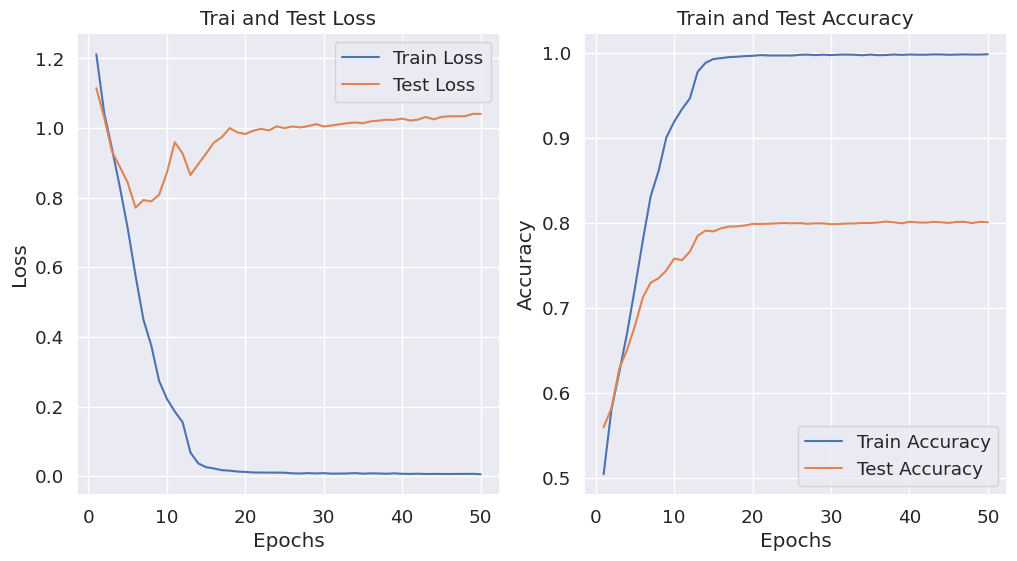

In [157]:
epochs=50
result = train(epochs=epochs,
      train_dataloader = train_dataloader,
      test_dataloader = test_dataloader,
      model = model,
      loss_fn = loss_fn,
      optimizer = optimizer,
      accuracy_fn = acc_fn,
      device = device)

plot_results(result,epochs)

### Zapisywanie modelu

In [158]:
torch.save(model.state_dict(), '/content/drive/MyDrive/WUM/Model/Model_CNN1_2.pth')

## Ewaluacja

In [159]:
# imports
import time
import random

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import librosa

import torch
import torch.nn as nn
import torch.optim as optim
!pip -q install torchmetrics
from torchmetrics import Accuracy
import IPython.display as ipd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from torch.utils.data import Dataset, DataLoader
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Wczytanie modelu

In [160]:
#model = LSTM(in_features, hidden_nodes, num_layers, out_features).to(device)
model = CNN(sequence_length=1, out_features=6).to(device)
#model = CNNLSTM(sequence_length, out_features).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=6).to(device) # send accuracy function to device

model.load_state_dict(torch.load('/content/drive/MyDrive/WUM/Model/Model_CNN1.pth', map_location=torch.device(device)))

<All keys matched successfully>

### Funkcja do ewaluacji

In [161]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: str):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device: 'cuda' or 'cpu'

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            X, y = X.to(device), y.to(device)

            y_pred = model(X).to(device)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y,
                                y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc.item()}


### Ewaluacja modelu

In [162]:
class torchDataset(Dataset):
    """
    A custom Dataset class for loading features and labels from a CSV file,
    where features are stored as string representations of lists that need
    to be converted to numpy arrays and then to Torch tensors.
    """
    def __init__(self, csv_file, device: str):
        """
        Args:
            csv_file (str): Path to the CSV file.
        """
        # Load the data from a CSV file
        self.df = pd.read_csv(csv_file)

        # Convert features from strings to numpy arrays
        self.features = [self.convert_string_to_array(feature_string)
                         for feature_string in self.df['Features']]
        self.features = np.vstack(self.features)  # Stack to create a 2D array
        self.features = torch.tensor(self.features, dtype=torch.float, device = device)  # Convert to torch.Tensor
        self.features = torch.tensor(self.features, dtype=torch.float, device = device).unsqueeze(1)  # Add dimension | MODEL DIMENSIONS = [batch_size, sequence_length, input_length]

        # Convert labels to a torch tensor
        self.labels = torch.tensor(self.df['labels'].values, dtype=torch.long)

    def convert_string_to_array(self, feature_string):
        """
        Converts a string representation of a list into a numpy array.
        """
        try:
            # Parse the string to a list
            feature_list = ast.literal_eval(feature_string)
            return np.array(feature_list, dtype=float)
        except Exception as e:
            print(f"Error parsing string to array: {e}")
            return np.array([], dtype=float)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieves the feature tensor and label for a given index.

        Args:
            idx (int): Index of the data point to retrieve.

        Returns:
            tuple: (feature, label) where feature is a tensor of features and label is a single value tensor.
        """
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label

In [163]:
TEST_PATH = '/content/drive/MyDrive/WUM/Test/test_labels_features_dataframe.csv'
test_data = torchDataset(TEST_PATH,device)
test_dataloader = DataLoader(test_data,
                              batch_size=128)

In [164]:
model_ = eval_model(model=model,
           data_loader=test_dataloader,
           loss_fn = loss_fn,
           accuracy_fn = acc_fn,
           device = device)
model_

{'model_name': 'CNN',
 'model_loss': 0.9968504309654236,
 'model_acc': 0.8024962544441223}

Zczyatnie z pliku ścieżek plików audio (paths) i etykiet (labels)

In [165]:
df = pd.read_csv('/content/drive/MyDrive/WUM/Recordings_Dataframe/data_path_WUM.csv')

paths = df["Speech"].tolist()
labels = df["labels"].tolist()

In [166]:
# Metoda MFCC
def extract_mfcc(n, y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n,hop_length=512)
    mfccs = np.mean(mfccs.T, axis=0)
    return mfccs

# Metoda Root Mean Squeare - RMS
def extract_rms(y):
    rms = np.mean(librosa.feature.rms(y=y,frame_length=2048,hop_length=512)[0])
    return np.squeeze(rms)

# Metoda Chroma-STFT
def extract_chroma(n, y, sr):
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma = n, hop_length=512)
    chroma = np.mean(chroma.T, axis=0)
    return chroma

# Metoda Zero Crossing Rate - ZCR
def extract_zcr(y):
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=y,frame_length=2048,hop_length=512)[0])
  return np.squeeze(zcr)

In [167]:
def extract_features(path):
  y, sr = librosa.load(path, duration=2.5, offset=0.5)
  result = np.hstack((
      extract_zcr(y),
      extract_rms(y),
      extract_mfcc(42,y,sr),
      extract_chroma(24,y,sr)
  ))
  result = np.array(result)
  #result = np.zeros(68)
  return result

### Predykcja na dziesięciu losowych plikach audio

Wybranie radnomowej próbki z bazy danych

In [168]:
#N_samples = 10
#sample_list = []
#for i in range(N_samples):
random_sample_index = random.randint(0, len(paths) - 1)
random_sample_path = paths[random_sample_index]
random_sample_label = labels[random_sample_index]

ipd.Audio(random_sample_path)

def get_prediction_input(path):
  features = extract_features(path)
  features = features.astype(np.float32)
  features = np.expand_dims(features, axis=0)
  features = scaler.transform(features)
  features = np.expand_dims(features, axis=0)
  return torch.from_numpy(features).to(device)

features = get_prediction_input(random_sample_path)
random_sample_label

'fear'

In [169]:
emotions={0: "angry",1: "happy", 2: "sad", 3: "disgust", 4: "fear", 5: "neutral"}
def predict(path):
  data = get_prediction_input(path)
  model.eval()
  with torch.inference_mode():
    prediction = model(data).to(device)
    predicted_class = prediction.argmax(dim=1)
    return predicted_class[0]

print(emotions[int(predict((random_sample_path)))])

fear


In [170]:
def batch_predict(dataloader):
    all_predictions = []
    all_labels = []

    model.eval()
    with torch.no_grad():  # torch.inference_mode() if you're using PyTorch 1.9 or later
        for batch, (data, labels) in enumerate(dataloader):
            data = data.to(device)  # ensure data is on the right device
            predictions = model(data)
            _, predicted_classes = torch.max(predictions, 1)

            all_predictions.extend(predicted_classes.cpu().numpy())  # collect predictions
            all_labels.extend(labels.cpu().numpy())  # collect actual labels
            if batch % 500 == 0:
                print(batch)

    return all_predictions, all_labels

predictions, labels = batch_predict(test_dataloader)

0


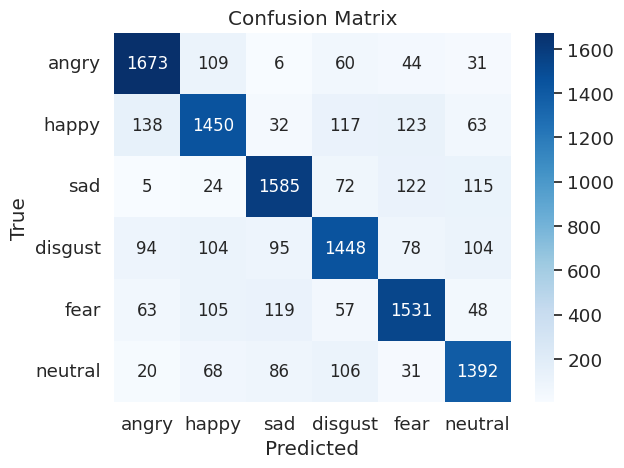

In [171]:
conf_matrix = confusion_matrix(labels, predictions)
emotions = {0: "angry", 1: "happy", 2: "sad", 3: "disgust", 4: "fear", 5: "neutral"}

sns.heatmap(conf_matrix, annot=True, fmt='g',
            cmap='Blues',annot_kws={"size": 12},
            xticklabels=list(emotions.values()),
            yticklabels=list(emotions.values()))
plt.xlabel('Predicted')

plt.ylabel('True')
plt.yticks(rotation=0)
plt.title('Confusion Matrix')
plt.show()